In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout,Flatten, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pathlib
import pandas as pd
import re

In [0]:
!tar xzf drive/My\ Drive/alcon2019.tar.gz

In [0]:
img_dir = pathlib.Path('alcon2019/dataset/train/imgs')
label_dir = 'alcon2019/dataset/train/annotations.csv'
IMAGE_DIMS = (512, 128, 1)
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
my_num = 10000

In [0]:
labels = pd.read_csv(label_dir)
labels = labels[["Unicode1", "Unicode2", "Unicode3"]].values.tolist()
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(np.array(labels))
img_paths = [str(x) for x in img_dir.glob('*')]
img_paths.sort(key=lambda x: int(re.findall(r'\d+(?=\.jpg)', x)[0]))

In [0]:
def read_preprocess_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    img = img_to_array(img)
    return img

In [0]:
# def create_dataset(l=0, r=100, cnt=100):
#   img_paths_tmp = img_paths[l:r]
#   labels_tmp = labels[l:r]
#   image_count = cnt
#   path_ds = tf.data.Dataset.from_tensor_slices(img_paths_tmp)
#   img_ds = path_ds.map(read_preprocess_img, num_parallel_calls=AUTOTUNE)
#   label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels_tmp, tf.int32))
#   image_label_ds = tf.data.Dataset.zip((img_ds, label_ds))
#   ds = image_label_ds.shuffle(buffer_size=image_count)
#   ds = ds.repeat()
#   ds = ds.batch(BS)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

def create_dataset(l=0, r=100):
  img_paths_tmp = img_paths[l:r]
  labels_tmp = labels[l:r]
  data = [read_preprocess_img(x) for x in img_paths_tmp]
  data = np.array(data, dtype="float") / 255.0
  return data, labels_tmp

In [0]:
my_data, my_labels = create_dataset(r=my_num)

In [0]:
(trainX, testX, trainY, testY) = train_test_split(my_data,
	my_labels, test_size=0.2, random_state=42)

In [0]:
def make_model():
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
    
    
		model = Sequential()
		inputShape = IMAGE_DIMS
		chanDim = -1


		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=inputShape))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024, activation="relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(len(mlb.classes_), activation="sigmoid"))

		# return the constructed network architecture
		return model

In [139]:
print("[INFO] compiling model...")
model = make_model()
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [140]:
model.fit(trainX, trainY, epochs=EPOCHS, validation_data=(testX, testY), batch_size=BS)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 43s 5ms/sample - loss: 0.3282 - acc: 0.8660 - val_loss: 0.5370 - val_acc: 0.8760
Epoch 2/10
8000/8000 [==============================] - 36s 4ms/sample - loss: 0.1548 - acc: 0.9484 - val_loss: 0.1811 - val_acc: 0.9407
Epoch 3/10
8000/8000 [==============================] - 36s 4ms/sample - loss: 0.1213 - acc: 0.9579 - val_loss: 0.5056 - val_acc: 0.8010
Epoch 4/10
8000/8000 [==============================] - 36s 4ms/sample - loss: 0.0951 - acc: 0.9664 - val_loss: 0.2706 - val_acc: 0.9245
Epoch 5/10
8000/8000 [==============================] - 36s 4ms/sample - loss: 0.0706 - acc: 0.9748 - val_loss: 1.5790 - val_acc: 0.8373
Epoch 6/10
8000/8000 [==============================] - 36s 4ms/sample - loss: 0.0525 - acc: 0.9814 - val_loss: 0.1593 - val_acc: 0.9535
Epoch 7/10
8000/8000 [==============================] - 36s 4ms/sample - loss: 0.0383 - acc: 0.9866 - val_loss: 0.1427 - val_acc: 

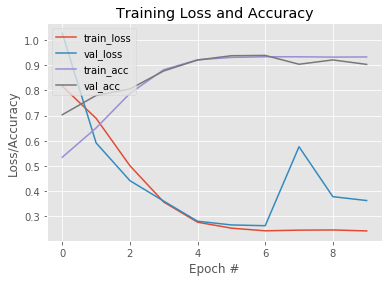

In [141]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [0]:
image = cv2.imread(img_paths[0], cv2.IMREAD_GRAYSCALE)
 
# pre-process the image for classification
image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
proba = model.predict(image)[0]
idxs = np.argsort(proba)[::-1]

In [151]:
model.predict(image)[0]

array([3.0634487e-01, 3.3915043e-05, 4.6402216e-05, 1.4275312e-05,
       4.4089556e-04, 4.3243170e-05, 1.3727546e-03, 3.9637089e-06,
       2.7960539e-04, 5.3745508e-04, 1.3449788e-04, 8.0779493e-03,
       3.9666891e-05, 7.7027082e-04, 7.1775913e-04, 2.1119550e-01,
       9.6985698e-04, 7.3076254e-01, 3.8668513e-04, 7.9826629e-01,
       1.2308359e-05, 1.6093254e-06, 6.8306923e-05, 1.1771917e-05,
       1.5339255e-03, 5.0961971e-06, 4.8279762e-06, 4.8327446e-04,
       9.8913908e-05, 7.1678162e-03, 1.7285347e-06, 4.2395324e-02,
       6.3866377e-05, 7.0309639e-04, 2.8827786e-03, 2.7105570e-01,
       8.8110566e-04, 3.3378601e-06, 7.7486038e-07, 6.5784514e-02,
       3.3617020e-05, 3.9456278e-02, 6.9737434e-06, 1.6858459e-02,
       1.1920929e-07, 8.3684921e-05, 3.1172037e-03, 4.9840212e-03],
      dtype=float32)

In [157]:
for (i, j) in enumerate(idxs):
  label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
  print(label)

U+3068: 79.83%
U+3064: 73.08%
U+3042: 30.63%
